# Regression model to predict the house price

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 12, 8

### Reading data

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [4]:
train_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

Train set is comparable in size to the test set. Target column ('SalePrice') is present only in the train set.

In [5]:
train_data.shape

(1460, 81)

In [6]:
test_data.shape

(1459, 80)

In [7]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Defining target value and input features

This competition requires to predict total price of the house based on the given numeric and categorical features. In appraisal industry it is generally considered the best approach to estimate the price of real estate per sq.m or sq.ft. Total price is then calculated by multiplying the price per sq.m or sq.ft by the floor area. The reason for that being that size of the house in itself is a parameter, which affects the price per sq.m (the larger the house - the smaller the price per sq.m).

In [8]:
# Total square footage of the house (basement + 1st floor + 2nd floor)
house_size = (train_data['TotalBsmtSF'] + train_data['1stFlrSF'] + train_data['2ndFlrSF'])

In [9]:
# Target value will be modified to price per sq.ft of total area
y_train = train_data['SalePrice'] / house_size

In [10]:
# Input features with the exception of the sale price and object ID
x_train = train_data.drop(['Id', 'SalePrice'], axis='columns')

### Dealing with missing values and categorical features

The data requires preprocessing in tearms of dealing with missing values and categorical features. Shuffling the train samples in this case is not necessary because original data is not sorted in any way.

All input features that are available in the dataset are relevant to the purpose of pricing the house, though they vary in their significance. The best approach would be to use as much original features as possible and fit the data to some kind of decision tree algorithm, which automatically detects the most important features.

In [11]:
# Checking how many values are missing
missing_vals = train_data.isna().sum()
print(missing_vals[missing_vals > 0])

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


Some of the input features have high share of missing values, which makes them less useful for the model. These features are relatively few, and by their names we can safely assume they are not crucial. Only the features with less than 100 missing values will be retained for the further analysis.

In [12]:
# Drop columns with more than 100 missing values
columns_to_drop = missing_vals[missing_vals > 100].index
x_train = x_train.drop(columns_to_drop, axis='columns')
print(columns_to_drop)

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


Missing values in remaining columns will be imputed using 'median' strategy for numeric columns and 'most_frequent' strategy for categorical columns. Some of the columns that do not contain NaNs in the train set have missing values in the test set. To simplify and automate data processing we add numeric and categorical features with NaNs to lists, which will be used in a column transformer as part of the data processing and modelling pipeline.

In [13]:
# Columns by data type
cat_columns = list(x_train.select_dtypes(include=['category', 'object']).columns)
num_columns = list(x_train.select_dtypes(include=['number']).columns)

In [14]:
# Numeric columns to be imputed
missing_num_vals = x_train[num_columns].isna().sum()
median_columns = set(missing_num_vals[missing_num_vals > 0].index)

In [15]:
# Adding numeric columns from the test set
missing_num_vals = test_data[num_columns].isna().sum()
median_columns = list(median_columns.union(set(missing_num_vals[missing_num_vals > 0].index)))

In [16]:
median_columns

['TotalBsmtSF',
 'GarageYrBlt',
 'BsmtFinSF1',
 'GarageArea',
 'BsmtHalfBath',
 'BsmtFullBath',
 'BsmtUnfSF',
 'BsmtFinSF2',
 'MasVnrArea',
 'GarageCars']

In [17]:
# Imputing missing values, one-hot-encoding categorical columns
imp_median = SimpleImputer(strategy='median')
imp_freq = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder(sparse=False)

cat_transformer = make_pipeline(imp_freq, ohe)

col_transformer = make_column_transformer((imp_median, median_columns),
                                          (cat_transformer, cat_columns),
                                          remainder='passthrough')

### Making pipeline for regression model

In [18]:
# Combine column transformer with regression model
regr_model = RandomForestRegressor()
pipe_RF = make_pipeline(col_transformer, regr_model)

In [19]:
# Training the model
pipe_RF.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['TotalBsmtSF', 'GarageYrBlt',
                                                   'BsmtFinSF1', 'GarageArea',
                                                   'BsmtHalfBath',
                                                   'BsmtFullBath', 'BsmtUnfSF',
                                                   'BsmtFinSF2', 'MasVnrArea',
                                                   'GarageCars']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='...
                                                   'LandS

### Evaluating the model on the train set

In practice when appraisal specialists create evaluation models they tend to filter out outliers - objects with uptypically high or low prices, that could not be justified by the stardard regression model. Outliers in the real estate market usually belong to one of the following groups:
- unique properties with rare features that are not captured in the stardard description;
- properties sold on special conditions (seller looking for a quick deal, etc.);
- errors in property description.

Taking that into account, the optimal metrics to evaluate the house price model would be R2 (determination coefficient) and MAE (Mean Absolute Error). MSE (Mean Squared Error) in this case should not be considered as it amplifies the importance of outliers.

In [20]:
# Predicting price per sq.ft.
y_pred = pipe_RF.predict(x_train)

In [21]:
# Evaluating the errors based on actual and predicted price per sq.ft.
MAE = mean_absolute_error(y_pred, y_train)
R2 = r2_score(y_pred, y_train)
print(f'RandomForest price prediction per sq.ft\nMAE = {MAE}\nR2 = {R2}')

RandomForest price prediction per sq.ft
MAE = 2.278143021821523
R2 = 0.9392087794179889


In [22]:
# Average value of the predicted parameter and MAE to average value ratio
av_price_sqft = np.mean(y_train)
print(f'Average price per sq.ft. = {av_price_sqft}\nMAE/av.price = {MAE/av_price_sqft}')

Average price per sq.ft. = 69.94400034735276
MAE/av.price = 0.03257095691564554


In [23]:
# Calculating total price of the house
train_result = pd.DataFrame({'prediction_sqft': y_pred, 'house_size': house_size})
train_result['prediction_total'] = train_result['prediction_sqft'] * train_result['house_size']

In [24]:
train_result.head()

,prediction_sqft,house_size,prediction_total
0,80.734491,2566,207164.703293
1,69.855574,2524,176315.467536
2,81.596293,2706,220799.567519
3,57.419076,2473,141997.375651
4,77.422675,3343,258824.001692


In [25]:
# Evaluating the errors based on actual and predicted price for the house
MAE = mean_absolute_error(train_result['prediction_total'], train_data['SalePrice'])
R2 = r2_score(train_result['prediction_total'], train_data['SalePrice'])
print(f'RandomForest price prediction\nMAE={MAE}\nR2={R2}')

RandomForest price prediction
MAE=6175.742080245101
R2=0.9696755128222536


In [26]:
# Average price of the house in the train set and MAE to average value ratio
av_house_price = train_data['SalePrice'].mean()
print(f'Average house price = {av_house_price}\nMAE/av.price = {MAE/av_house_price}')

Average house price = 180921.19589041095
MAE/av.price = 0.03413498374168343


In [27]:
# Absolute errors
train_result['SalePrice'] = train_data['SalePrice']
train_result['AbsError'] = abs(train_result['prediction_total'] - train_result['SalePrice'])

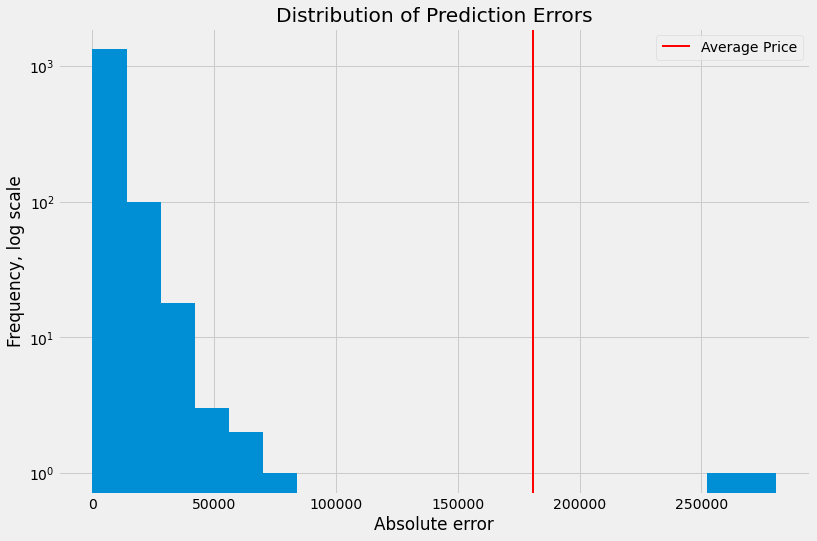

In [28]:
# Distribution of errors and their magnitude
plt.hist(train_result['AbsError'], bins=20, log=True)
plt.axvline(av_house_price, color='red', label='Average Price', linewidth=2)
plt.legend()
plt.xlabel('Absolute error')
plt.ylabel('Frequency, log scale')
plt.title('Distribution of Prediction Errors')
plt.show()

The histogram shows that large-scale errors are rare for the model and most likely caused by some errors in the original data or non-typical objects present in the dataset. These objects represent minor share of the training set, however they can significantly distort and skew the regression model. To improve the model quality and robustness to extreme outliers we can eliminate them from the training set altogether.

In [29]:
outliers = train_result[train_result['AbsError'] > 200_000]
outliers_indexes = outliers.index
outliers

,prediction_sqft,house_size,prediction_total,SalePrice,AbsError
523,57.712507,7814,450965.528840,184750,266215.528840
1298,37.481443,11752,440481.912622,160000,280481.912622


In [30]:
# Removing outliers from input data and targets
x_train.drop(outliers_indexes, inplace=True)
y_train.drop(outliers_indexes, inplace=True)

In [31]:
# Retraining the model on data cleaned from extreme outliers
pipe_RF.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['TotalBsmtSF', 'GarageYrBlt',
                                                   'BsmtFinSF1', 'GarageArea',
                                                   'BsmtHalfBath',
                                                   'BsmtFullBath', 'BsmtUnfSF',
                                                   'BsmtFinSF2', 'MasVnrArea',
                                                   'GarageCars']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='...
                                                   'LandS

In [32]:
# Predicting price per suare foot
y_pred = pipe_RF.predict(x_train)

In [33]:
# Evaluating the errors based on actual and predicted price per sq. foot
MAE = mean_absolute_error(y_pred, y_train)
R2 = r2_score(y_pred, y_train)
print(f'RandomForest price prediction per sq.ft\nMAE = {MAE}\nR2 = {R2}')

RandomForest price prediction per sq.ft
MAE = 2.2319903312484293
R2 = 0.945490724962554


To improve prediction accuracy we can train other regression models on the same data cleaned from extreme outliers with the same preprocessing steps and compare the metrics with results demonstrated by RandomForest model.

We will check the accuracy of GradientBoosting model. Unlike RandomForest, which can work on unscaled data, for this model we will modify the column transformer to include scaling for numeric features.

In [34]:
# Modifying the column transformer
scaler = StandardScaler()
num_transformer = make_pipeline(imp_median, scaler)
col_transformer_scaled = make_column_transformer((num_transformer, num_columns),
                                                 (cat_transformer, cat_columns),
                                                 remainder='passthrough')

In [35]:
# Training GradientBoosting model
pipe_GB = make_pipeline(col_transformer_scaled, GradientBoostingRegressor())
pipe_GB.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['MSSubClass', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBs...
                      

In [36]:
# Evaluating the model
pipe_GB.predict(x_train)
MAE = mean_absolute_error(y_pred, y_train)
R2 = r2_score(y_pred, y_train)
print(f'GradientBoosting prediction per sq.ft.\nMAE = {MAE}\nR2 = {R2}')

GradientBoosting prediction per sq.ft.
MAE = 2.2319903312484293
R2 = 0.945490724962554


GradientBoosting model did not improved the prediction accuracy. For this task both models are appropriate.

### Making prediction on the test set

In [37]:
# One of the test data samples contains NaN value in the 'TotalBsmtSF' column
test_data['TotalBsmtSF'].isna().sum()

1

In [38]:
# We can assume in this case that missing value means there is no basement in the house
test_data['TotalBsmtSF'] = test_data['TotalBsmtSF'].fillna(0)

In [39]:
# Calculate total floor area of the houses in the test set
# to be able to get the sale price from predicted price per sq.ft.
house_size = (test_data['TotalBsmtSF'] + test_data['1stFlrSF'] + test_data['2ndFlrSF'])

In [40]:
# Drop unnecessary columns from the test data
x_test = test_data.drop('Id', axis='columns')
x_test = x_test.drop(columns_to_drop, axis='columns')

In [41]:
# Predicted price per sq.ft.
y_pred = pipe_RF.predict(x_test)

In [42]:
# Calculate total price based on the predicted price per sq.ft.
test_data['SalePrice_sq_ft'] = y_pred
test_data['Size'] = house_size
test_data['SalePrice'] = test_data['Size'] * test_data['SalePrice_sq_ft']

In [43]:
# Select data for submission
submission = test_data[['Id', 'SalePrice']]
submission.head()

,Id,SalePrice
0,1461,122550.629716
1,1462,166775.816329
2,1463,199016.219064
3,1464,195733.768832
4,1465,184395.413078


In [44]:
# Saving the results to csv file
submission.to_csv('submission.csv', index=False)